In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# **huggingface model custom**

저자 : 4nchez<br>
모델 : XLM-RoBERTa<br>
데이터 : nsmc<br>
필요한 라이브러리(중요한건 bold함)<br>
-> pandas, numpy, random, time, datetime, **transformers**, **pytorch**, **tensorflw**

## **Import library**

In [ ]:
!pip install transformers sentencepiece

     |████████████████████████████████| 1.5MB 9.0MB/s 
     |████████████████████████████████| 1.1MB 30.4MB/s 
     |████████████████████████████████| 2.9MB 43.6MB/s 
     |████████████████████████████████| 890kB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=47180b7280de3aaa082d4008e351a0140890810ece489751cba211de12df6d32
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random, time, datetime

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

## **데이터 로드**

In [ ]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 23.55 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


훈련셋 150,000개와 테스트셋 50,000개의 데이터가 존재합니다.
<br>
<br>
<br>

## **데이터 전처리**

**Train_set : validation_set = 9:1**

In [ ]:
def Make_sentence(tokenizer, sentences):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
      
  # input_ids = torch.cat(input_ids, dim=0)
  # attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [ ]:
# xlm-roberta-base
# !wget https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model
# xlm-roberta-large
# !wget https://huggingface.co/xlm-roberta-large/resolve/main/sentencepiece.bpe.model

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False)
# tokenizer = XLMRobertaTokenizer('sentencepiece.bpe.model', do_lower_case=False)

In [ ]:
# print(train.isnull().any())
# train[train['document'].isnull()]
print(train.shape)
print("train null value : " ,train.isnull().sum())
train_set=train.dropna()
sentences = train_set['document'].values
labels = train_set['label'].values
print(len(sentences))
print(len(labels))

input_ids, attention_masks = Make_sentence(tokenizer, sentences)
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', attention_masks[0])
print('Labels :', labels[0])

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(150000, 3)
train null value :  id          0
document    5
label       0
dtype: int64
149995
149995


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  아 더빙.. 진짜 짜증나네요 목소리
Token IDs: tensor([     0,   7159,   6116, 101895,      5,      5, 113621,      6,  74280,
         18128,   3497,  25861, 209932,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1

**Test_set**

In [ ]:
print(test.shape)
print(test.isnull().sum())
test_set=test.dropna()
print(test_set.shape)
sentences = test_set['document'].values
labels = test_set['label'].values
print(len(sentences))
print(len(labels))

input_ids, attention_masks = Make_sentence(tokenizer, sentences)
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', attention_masks[0])
print('Labels :', labels[0])

# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(input_ids, attention_masks, labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

(50000, 3)
id          0
document    3
label       0
dtype: int64
(49997, 3)
49997
49997


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  굳 ㅋ
Token IDs: tensor([     0,      6, 198249,      6, 204615,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1

## **모델 생성**

In [ ]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.num_labels = 2
          # from_pretrained 사용시 히든 사이즈 못바꿈!!
          self.config = XLMRobertaConfig.from_pretrained('xlm-roberta-base', output_hidden_states=True, 
                                                        #  num_hidden_layers=12, num_attention_heads=12,
                                                        #  hidden_size=768, intermediate_size=768*4, # 768, 768*4
                                                   hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
          self.roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base", config=self.config)
          # self.config = XLMRobertaConfig(
          #     attention_probs_dropout_prob= 0.1, hidden_dropout_prob=0.1,
          #     bos_token_id=0, pad_token_id=1, eos_token_id=2,
          #     gradient_checkpointing=False, hidden_act='gelu',
          #     hidden_size=768, intermediate_size=768*4, # 768, 768*4
          #     initializer_range=0.02, layer_norm_eps=1e-05, max_position_embeddings=514,
          #     num_attention_heads=2, num_hidden_layers=2,
          #     output_past=True, position_embedding_type="absolute",
          #     type_vocab_size=1, vocab_size=250002)
          # self.bert = XLMRobertaModel(self.config)
          ### New layers:
          # self.linear1 = nn.Linear(768, 768)
          self.lstm = nn.LSTM(input_size=768,
                            hidden_size=128,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True,
                            )
          self.dropout = nn.Dropout(0.1)
          self.linear2 = nn.Linear(128, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, labels=None, output_attentions=None,
                output_hidden_states=None, return_dict=None,):
          outputs = self.roberta(input_ids, attention_mask=attention_mask,
                              token_type_ids=token_type_ids, position_ids=position_ids,
                              head_mask=head_mask,inputs_embeds=inputs_embeds,
                              output_attentions=output_attentions, output_hidden_states=output_hidden_states,
                              return_dict=return_dict,)
          pooled_output = outputs[0]
          # return outputs
          lstm_output = self.lstm(pooled_output)
          lstm_out, (ht, ct) = self.lstm(pooled_output)
          # lstm_out, _ = self.lstm(pooled_output)
          # tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
          logits= self.linear2(ht[-1])

          loss = None
          if labels is not None:
              if self.num_labels == 1:
                  #  We are doing regression
                  loss_fct = MSELoss()
                  loss = loss_fct(logits.view(-1), labels.view(-1))
              else:
                  loss_fct = CrossEntropyLoss()
                  loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

          if not return_dict:
              output = (logits,) + outputs[2:]
              return ((loss,) + output) if loss is not None else output

          return logits

In [ ]:
# model = CustomBERTModel().to(device)
# # model = CustomBERTModel()
# print(model.config)

In [ ]:
from transformers import XLMRobertaForSequenceClassification
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
sum(p.numel() for p in model.parameters())

278045186

In [ ]:
# sum(p.numel() for p in model2.parameters())

In [ ]:
# # Get all of the model's parameters as a list of tuples.
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
parameters_to_prune = ()
# for i in range(12):
#     parameters_to_prune += (
#         (model.bert.encoder.layer[i].attention.self.key, 'weight'),
#         (model.bert.encoder.layer[i].attention.self.query, 'weight'),
#         (model.bert.encoder.layer[i].attention.self.value, 'weight'),
#     )

# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=0.2,
# )
for i in range(12):
    parameters_to_prune += (
        (model.roberta.encoder.layer[i].attention.self.key, 'weight'),
        (model.roberta.encoder.layer[i].attention.self.query, 'weight'),
        (model.roberta.encoder.layer[i].attention.self.value, 'weight'),
    )

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
for i in range(12):
    print(
        "Sparsity in Layer {}-th key weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.roberta.encoder.layer[i].attention.self.key.weight == 0))
            / float(model.roberta.encoder.layer[i].attention.self.key.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th query weightt: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.roberta.encoder.layer[i].attention.self.query.weight == 0))
            / float(model.roberta.encoder.layer[i].attention.self.query.weight.nelement())
        )
    )
    print(
        "Sparsity in Layer {}-th value weight: {:.2f}%".format(
            i+1,
            100. * float(torch.sum(model.roberta.encoder.layer[i].attention.self.value.weight == 0))
            / float(model.roberta.encoder.layer[i].attention.self.value.weight.nelement())
        )
    )
    print()

    
numerator, denominator = 0, 0
for i in range(12):
    numerator += torch.sum(model.roberta.encoder.layer[i].attention.self.key.weight == 0)
    numerator += torch.sum(model.roberta.encoder.layer[i].attention.self.query.weight == 0)
    numerator += torch.sum(model.roberta.encoder.layer[i].attention.self.value.weight == 0)

    denominator += model.roberta.encoder.layer[i].attention.self.key.weight.nelement()
    denominator += model.roberta.encoder.layer[i].attention.self.query.weight.nelement()
    denominator += model.roberta.encoder.layer[i].attention.self.value.weight.nelement()
    
print("Global sparsity: {:.2f}%".format(100. * float(numerator) / float(denominator)))

Sparsity in Layer 1-th key weight: 8.77%
Sparsity in Layer 1-th query weightt: 9.43%
Sparsity in Layer 1-th value weight: 30.25%

Sparsity in Layer 2-th key weight: 13.05%
Sparsity in Layer 2-th query weightt: 12.83%
Sparsity in Layer 2-th value weight: 32.48%

Sparsity in Layer 3-th key weight: 16.20%
Sparsity in Layer 3-th query weightt: 16.05%
Sparsity in Layer 3-th value weight: 30.37%

Sparsity in Layer 4-th key weight: 18.34%
Sparsity in Layer 4-th query weightt: 18.03%
Sparsity in Layer 4-th value weight: 25.54%

Sparsity in Layer 5-th key weight: 17.15%
Sparsity in Layer 5-th query weightt: 16.99%
Sparsity in Layer 5-th value weight: 25.25%

Sparsity in Layer 6-th key weight: 19.17%
Sparsity in Layer 6-th query weightt: 18.73%
Sparsity in Layer 6-th value weight: 24.63%

Sparsity in Layer 7-th key weight: 16.95%
Sparsity in Layer 7-th query weightt: 16.50%
Sparsity in Layer 7-th value weight: 27.09%

Sparsity in Layer 8-th key weight: 18.73%
Sparsity in Layer 8-th query weightt

In [ ]:
# for i in range(12):
#     print(
#         "Sparsity in Layer {}-th key weight: {:.2f}%".format(
#             i+1,
#             100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.key.weight == 0))
#             / float(model.bert.encoder.layer[i].attention.self.key.weight.nelement())
#         )
#     )
#     print(
#         "Sparsity in Layer {}-th query weightt: {:.2f}%".format(
#             i+1,
#             100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.query.weight == 0))
#             / float(model.bert.encoder.layer[i].attention.self.query.weight.nelement())
#         )
#     )
#     print(
#         "Sparsity in Layer {}-th value weight: {:.2f}%".format(
#             i+1,
#             100. * float(torch.sum(model.bert.encoder.layer[i].attention.self.value.weight == 0))
#             / float(model.bert.encoder.layer[i].attention.self.value.weight.nelement())
#         )
#     )
#     print()

    
# numerator, denominator = 0, 0
# for i in range(12):
#     numerator += torch.sum(model.bert.encoder.layer[i].attention.self.key.weight == 0)
#     numerator += torch.sum(model.bert.encoder.layer[i].attention.self.query.weight == 0)
#     numerator += torch.sum(model.bert.encoder.layer[i].attention.self.value.weight == 0)

#     denominator += model.bert.encoder.layer[i].attention.self.key.weight.nelement()
#     denominator += model.bert.encoder.layer[i].attention.self.query.weight.nelement()
#     denominator += model.bert.encoder.layer[i].attention.self.value.weight.nelement()
    
# print("Global sparsity: {:.2f}%".format(100. * float(numerator) / float(denominator)))

## **학습**

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
 
seed_val = 42
 
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
criterion = CrossEntropyLoss()
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    #               Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
 
    t0 = time.time()
 
    total_train_loss = 0
 
    model.train()
 
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels         
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
 
        model.zero_grad()        
 
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        # break
        loss = outputs[0]
        
        total_train_loss += loss.item()
 
        loss.backward()
 
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
        optimizer.step()
 
        scheduler.step()
 
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
 
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    #               Validation
    print("")
    print("Running Validation...")
 
    t0 = time.time()
    
    model.eval()
 
    total_eval_accuracy = 0
    total_eval_loss = 0
 
    for batch in validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]
            
        total_eval_loss += criterion(logits, b_labels)
 
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
 
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Accuracy: {0:.4f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
 
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
 
print("")
print("Training complete!")
 
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:25.
  Batch 1,000  of  4,219.    Elapsed: 0:12:49.
  Batch 1,500  of  4,219.    Elapsed: 0:19:14.
  Batch 2,000  of  4,219.    Elapsed: 0:25:39.
  Batch 2,500  of  4,219.    Elapsed: 0:32:03.
  Batch 3,000  of  4,219.    Elapsed: 0:38:28.
  Batch 3,500  of  4,219.    Elapsed: 0:44:52.
  Batch 4,000  of  4,219.    Elapsed: 0:51:17.

  Average training loss: 0.34
  Training epcoh took: 0:54:05

Running Validation...
  Validation Accuracy: 0.8852
  Validation Loss: 0.29
  Validation took: 0:01:47

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:06:25.
  Batch 1,000  of  4,219.    Elapsed: 0:12:49.
  Batch 1,500  of  4,219.    Elapsed: 0:19:14.
  Batch 2,000  of  4,219.    Elapsed: 0:25:39.
  Batch 2,500  of  4,219.    Elapsed: 0:32:03.
  Batch 3,000  of  4,219.    Elapsed: 0:38:28.
  Batch 3,500  of  4,219.    Elapsed: 0:44:53.
  Batch 4,000  of  4,219.    Elapsed: 0:51:

In [ ]:
import pandas as pd
 
# Display floats with two decimal places.
pd.set_option('precision', 4)
 
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
 
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
 
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
 
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.3382,"tensor(0.2908, device='cuda:0')",0.8852,0:54:05,0:01:47
2,0.2479,"tensor(0.2904, device='cuda:0')",0.8874,0:54:05,0:01:46
3,0.2004,"tensor(0.2849, device='cuda:0')",0.8945,0:54:04,0:01:46
4,0.1649,"tensor(0.3064, device='cuda:0')",0.8975,0:54:05,0:01:47


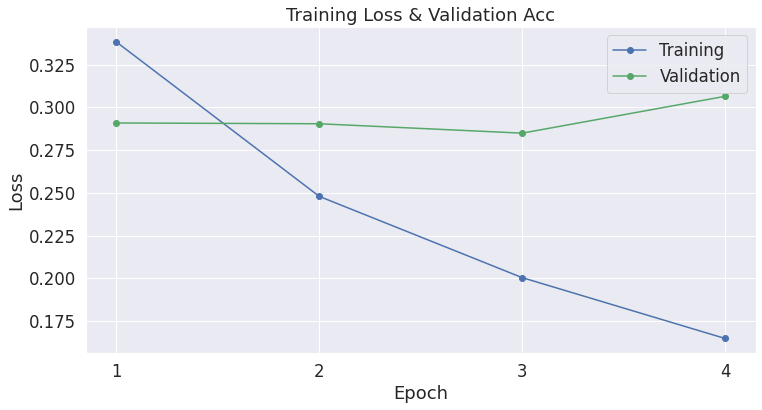

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
 
import seaborn as sns
 
# Use plot styling from seaborn.
sns.set(style='darkgrid')
 
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
 
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
 
# Label the plot.
plt.title("Training Loss & Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
 
plt.show()

## **테스트셋 평가**

In [28]:
#시작 시간 설정
t0 = time.time()
 
# 평가모드로 변경
model.eval()
 
# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
 
pred, real = [], [] #f1-score용 배열
# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 300 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))
 
    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]
 
    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred.append(np.argmax(logits, axis=1).flatten())
    real.append(label_ids.flatten())
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
 
print("")
print("Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   300  of  1,563.    Elapsed: 0:01:10.
  Batch   600  of  1,563.    Elapsed: 0:02:18.
  Batch   900  of  1,563.    Elapsed: 0:03:27.
  Batch 1,200  of  1,563.    Elapsed: 0:04:36.
  Batch 1,500  of  1,563.    Elapsed: 0:05:44.

Accuracy: 0.90056
Test took: 0:05:59


In [29]:
from sklearn.metrics import classification_report
print(classification_report(np.concatenate( real, axis=0 ),np.concatenate( pred, axis=0 ), digits=4))

              precision    recall  f1-score   support

           0     0.9069    0.8914    0.8991     24826
           1     0.8947    0.9097    0.9021     25171

    accuracy                         0.9006     49997
   macro avg     0.9008    0.9006    0.9006     49997
weighted avg     0.9007    0.9006    0.9006     49997



#Test

자바스크립트 30분(밀리초)<br>

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 1800000)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc